# Анализ временных рядов

В данном задании представлена визуализация, подбор оптимальных гиперпараметров для модели ARIMA и прогноз по построенной модели заработной платы в России. Данные представляют собой ежемесячную зарплату с января 1993 по август 2016.

## 1) Предварительный визуальный анализ ряда

Импортируем данные, построим график и сделаем декомпозицию, на их основании сделаем предварительные выводы о стационарности ряда и наличия в нем тренда и сезонности

In [92]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [111]:
salary = pd.read_csv('WAG_C_M.csv', header = 0, sep = ';', index_col = 'month', parse_dates=['month'], dayfirst=True)
print(salary.shape)
salary.head()

(284, 1)


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


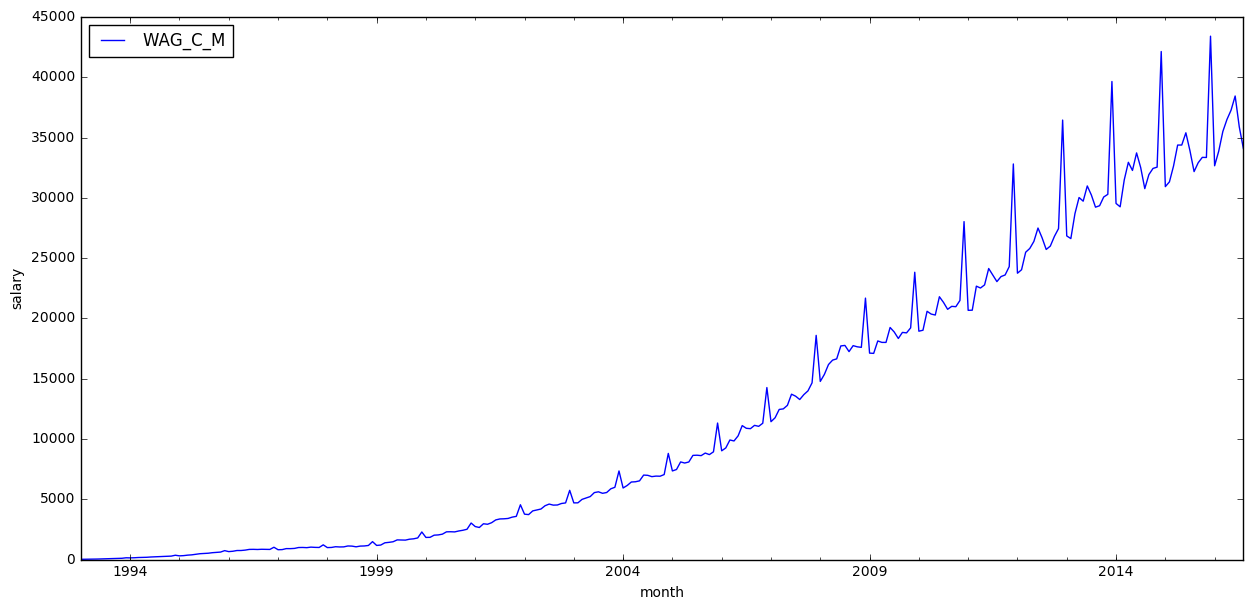

In [112]:
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('salary')
plt.show()

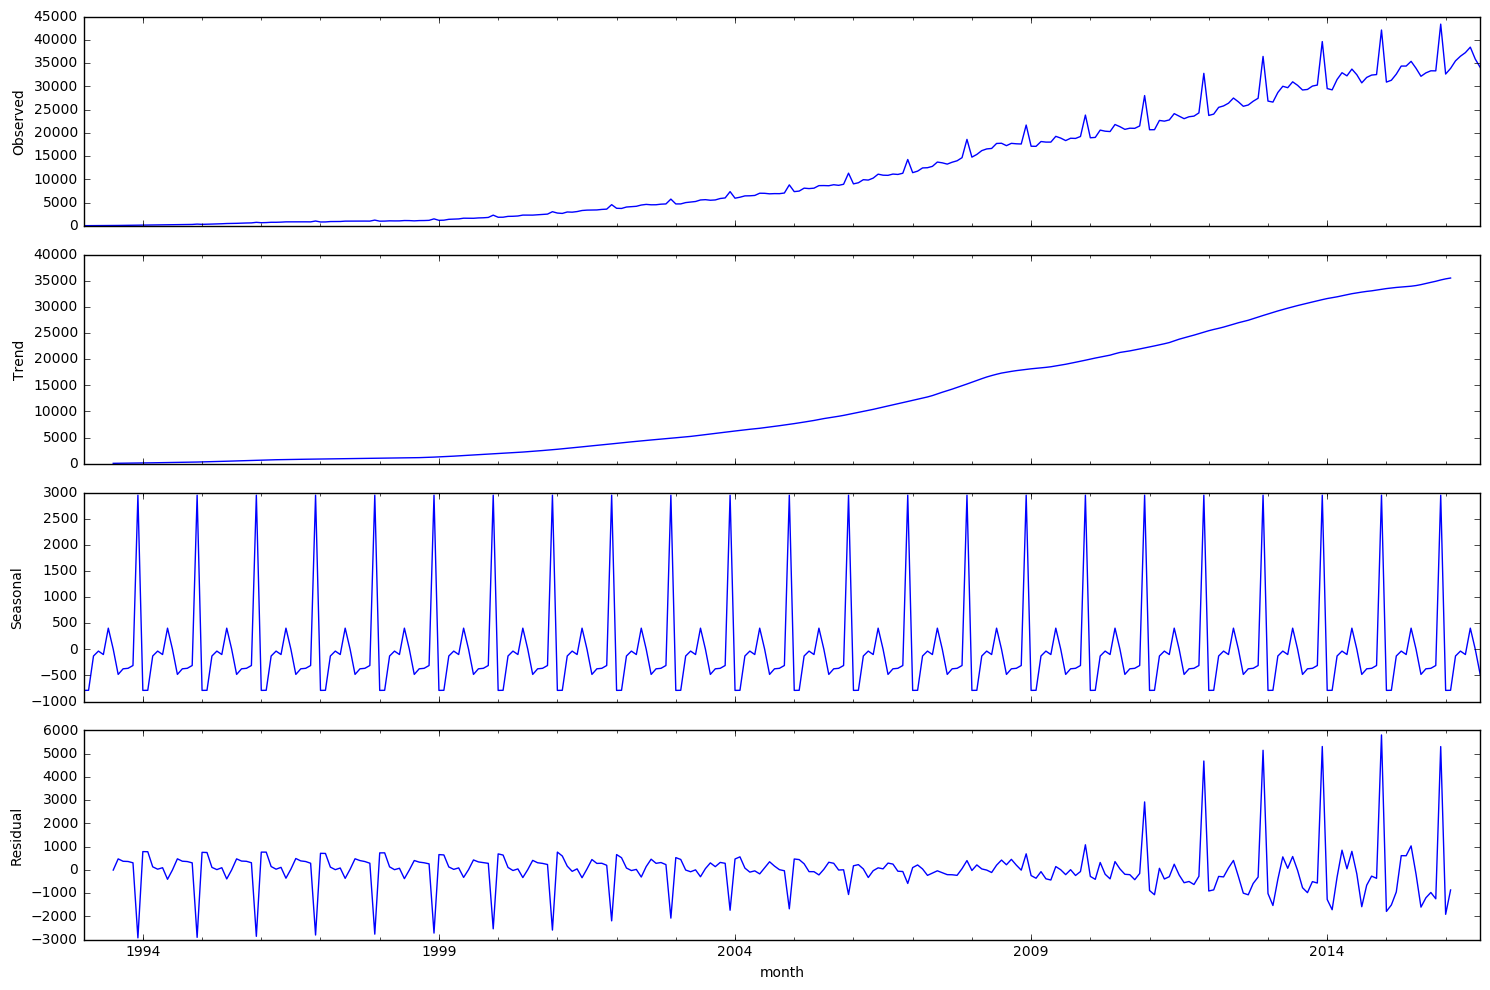

In [113]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['WAG_C_M']).plot()
plt.show()

По графику и декомпозиции ряда можно сделать следующие выводы:
 * Очевидно, что ряд не является стационарным, в нем присутствует положительный тренд
 * Среднеквадратическое отклонение ряда также не является постоянным, оно увеличивается со временем
 * В ряду присутствует годовая сезонность

## 2) Приведение ряда к стационарному

Применим преобразование Бокса-Кокса и сделаем сезонное дифференцирование. Полученный ряд проверим на стационарность тестом Дики-Фуллера. В случае нестационарности полученного ряда попробуем еще и обычное дифференцирование.

Box-Cox optimal lambda: 0.263202


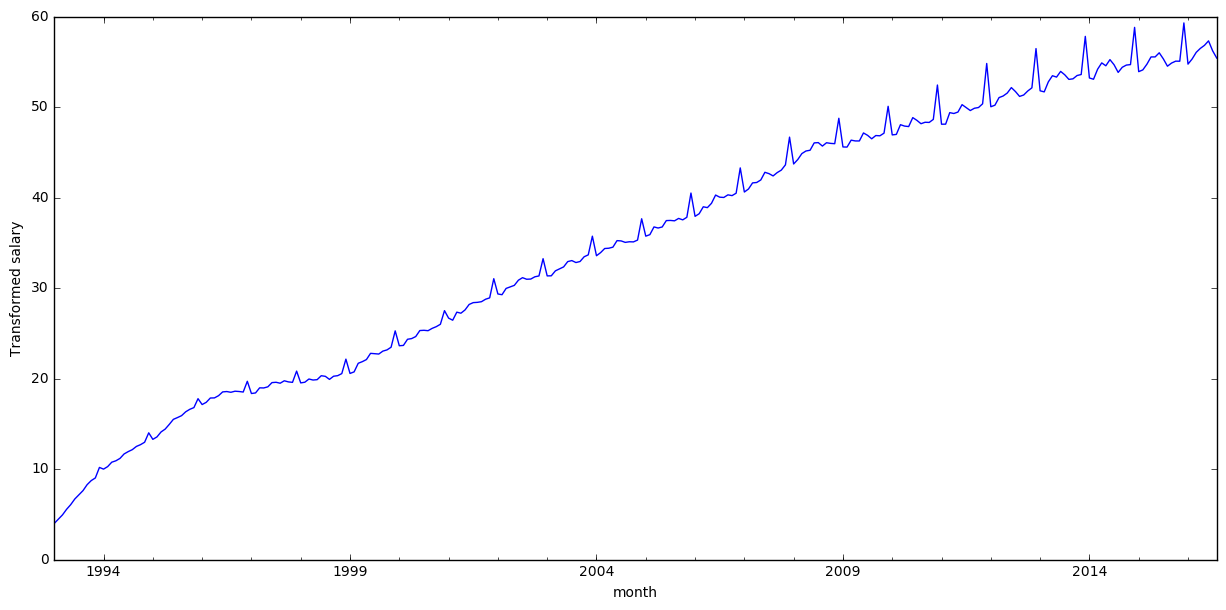

In [114]:
salary['salary_box'], lmbda = stats.boxcox(salary['WAG_C_M'])
print("Box-Cox optimal lambda: %f" % lmbda)
plt.figure(figsize(15,7))
salary['salary_box'].plot()
plt.ylabel('Transformed salary')
plt.show()

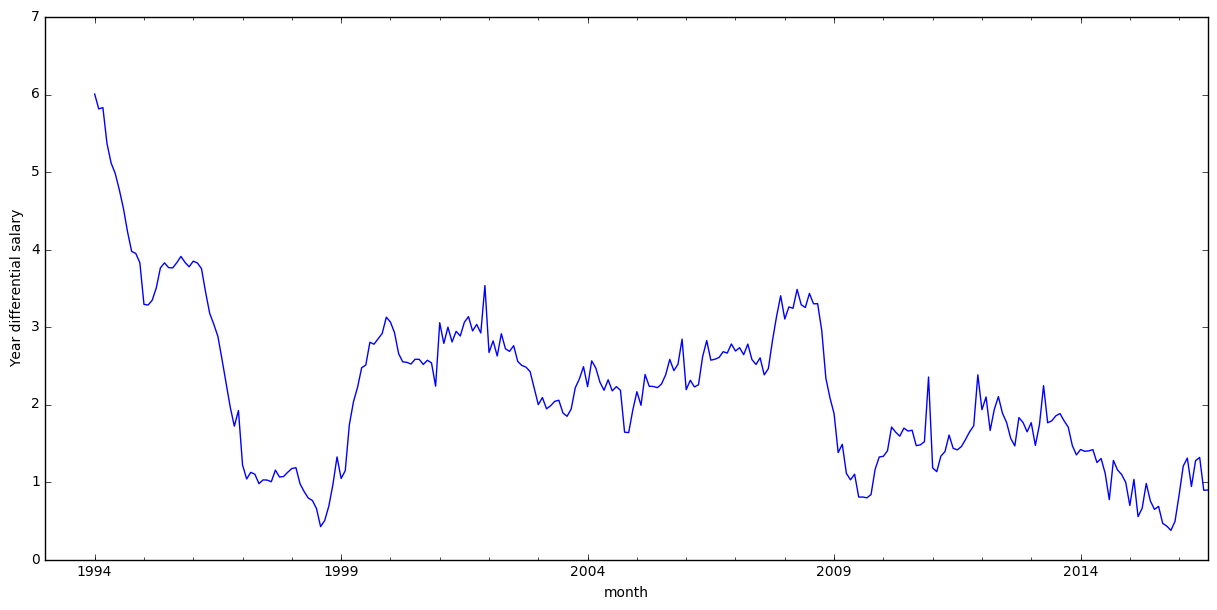

In [115]:
salary['salary12'] = salary['salary_box'] - salary['salary_box'].shift(12)
plt.figure(figsize(15,7))
salary['salary12'].plot()
plt.ylabel('Year differential salary')
plt.show()

Dickey-Fuller test's p-value: p=0.014697


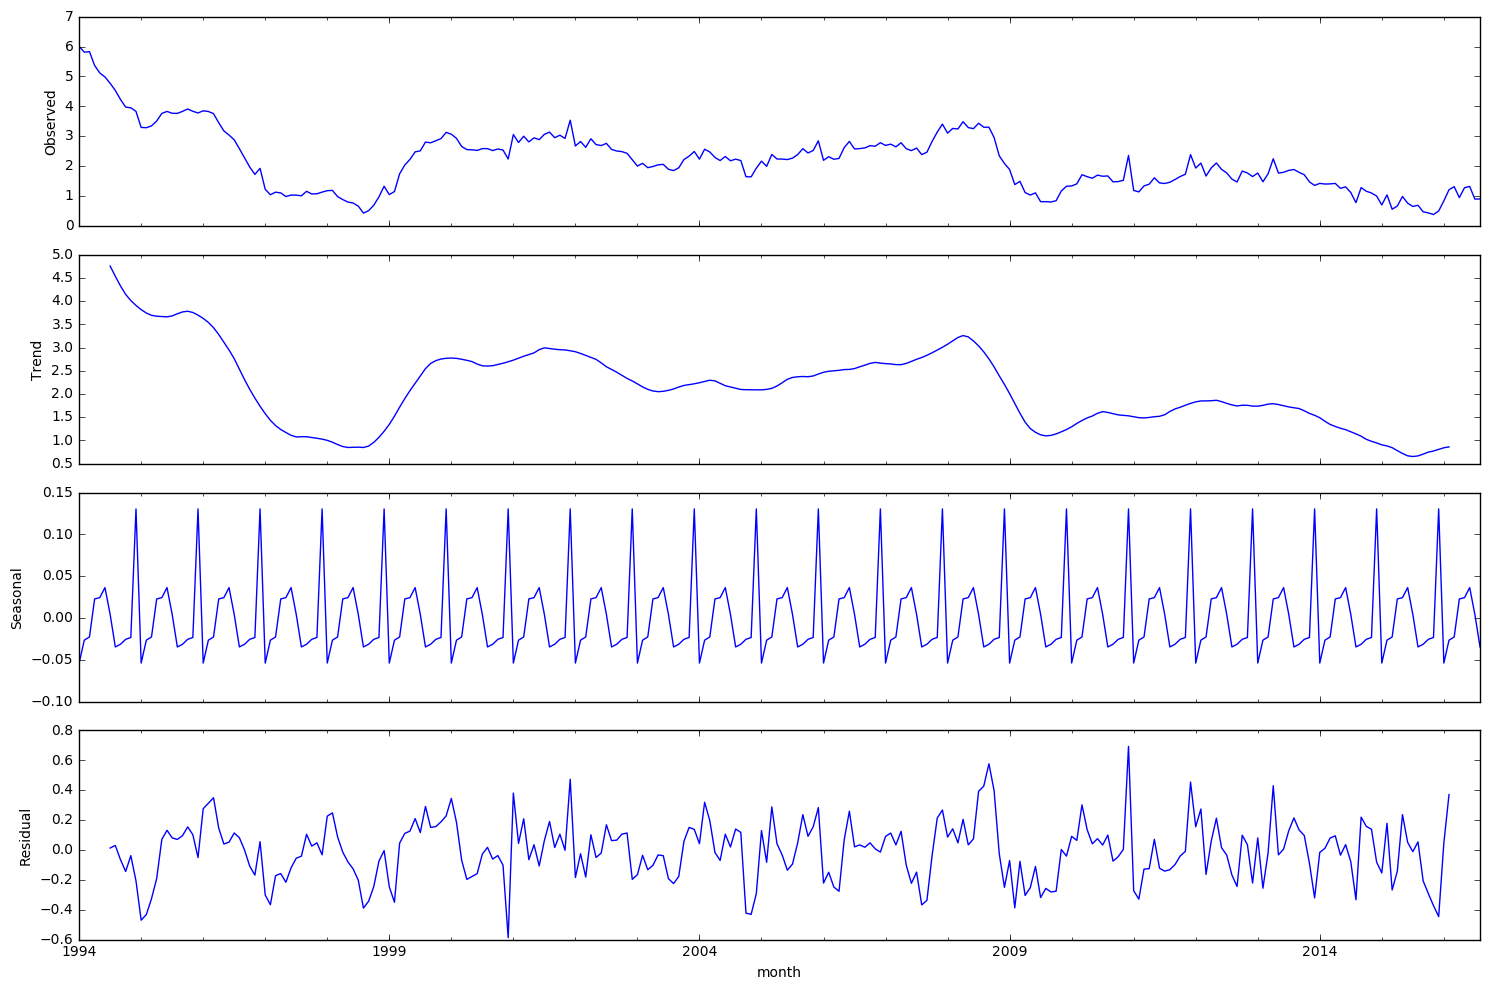

In [116]:
print("Dickey-Fuller test's p-value: p=%f" % sm.tsa.stattools.adfuller(salary.iloc[12:, 2])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.iloc[12:, 2]).plot()
plt.show()

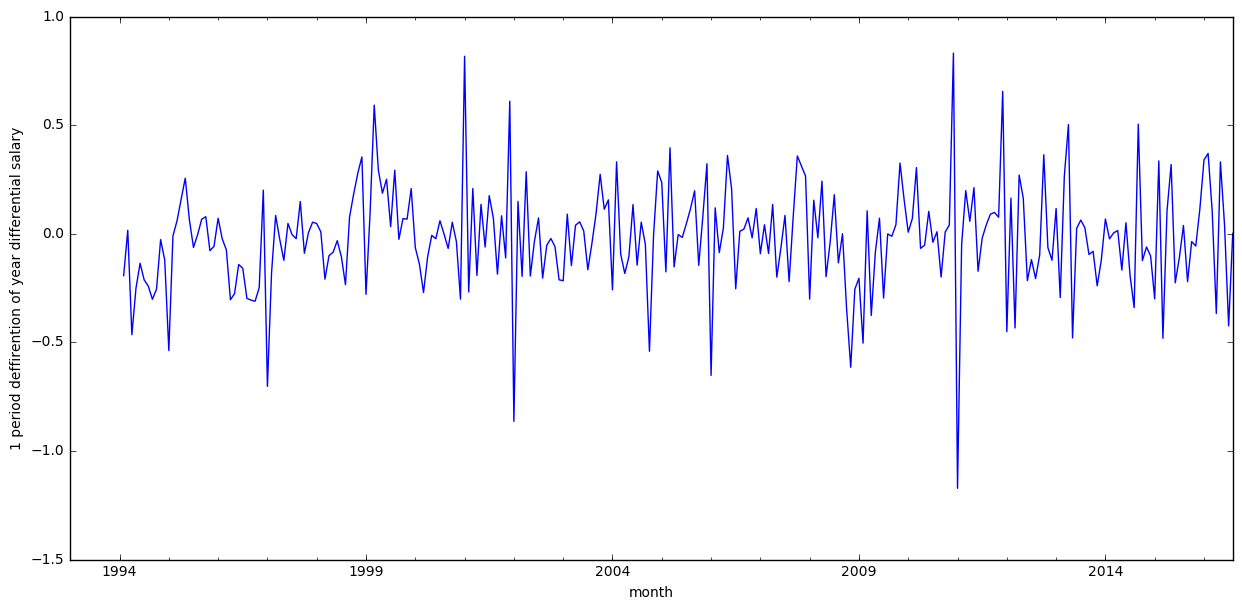

In [117]:
salary['salary13'] = salary['salary12'] - salary['salary12'].shift(1)
plt.figure(figsize(15,7))
salary['salary13'].plot()
plt.ylabel('1 period deffirention of year differential salary')
plt.show()

Dickey-Fuller test's p-value: p=0.000000


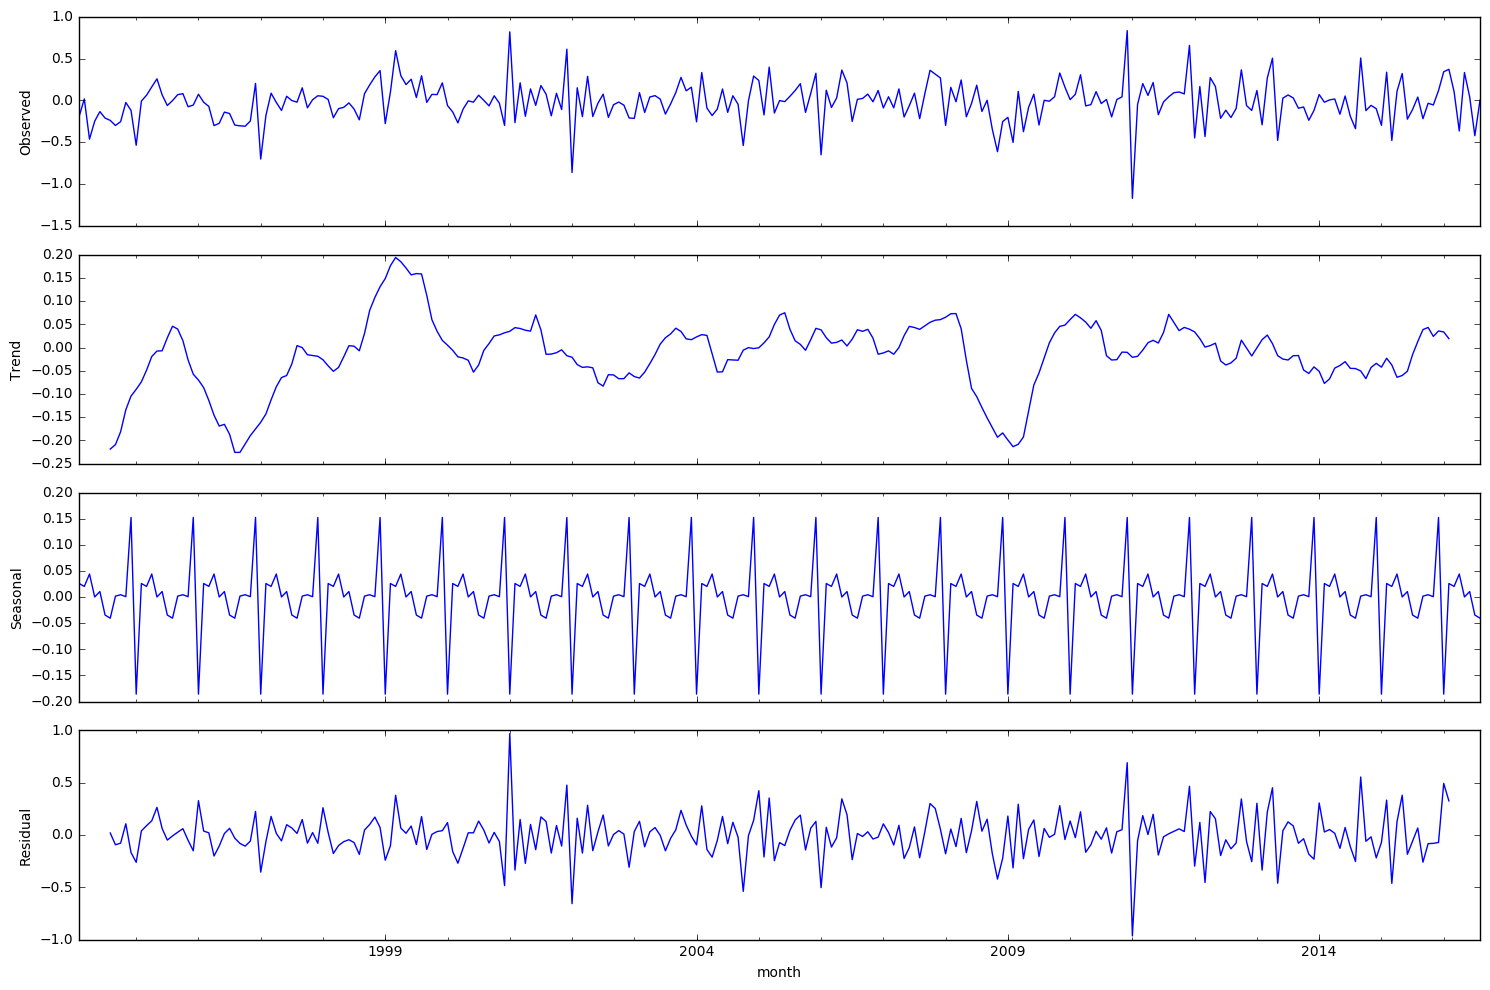

In [118]:
print("Dickey-Fuller test's p-value: p=%f" % sm.tsa.stattools.adfuller(salary.iloc[13:, 3])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.iloc[13:, 3]).plot()
plt.show()

Выводы:
* Преобразование Бокса-Кокса позволило сделать среднеквадратичное отклонение близким к постоянному (тем не менее по графику видно, что в начале наблюдений оно меньше, чем в конце)
* По тесту Дики-Фуллера ряд является стационарным уже после сезонного дифференцирования, его p_value $< 0.05$, но мы видим, что оно не позволило нам избавиться от тренда, поэтому необходимо еще одно дифференцирование на 1 период наблюдений
* В результате еще одного дифференцирования, мы получаем стационарный ряд, что видно как из теста Дики-Фуллера, так и из графика и декомпозиции. Именно с этим рядом мы и будем работать

## 3) Подбор начальный параметров

Выше мы подобрали гиперпараметры дифференцирования ряда, так $d = 1, D = 1$. Далее по графикам автокорреляции и частичной автокорреляции мы подберем начальные приближения гиперпараметров $p, P, q, Q$.

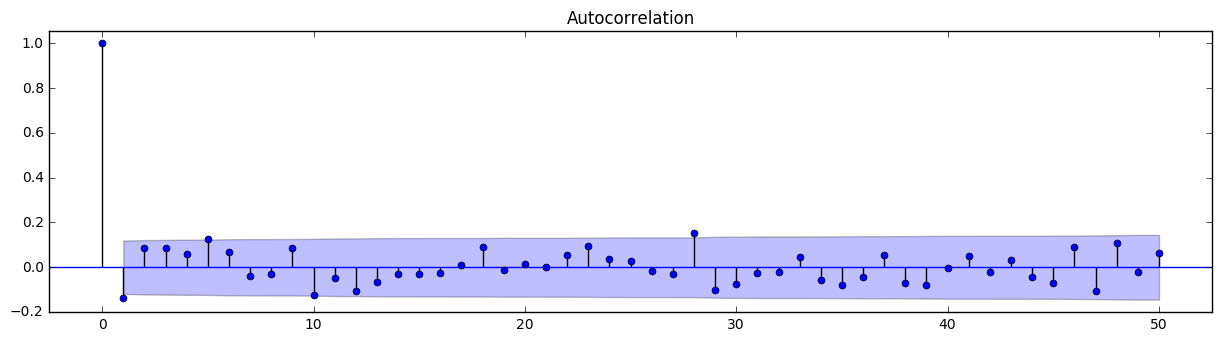

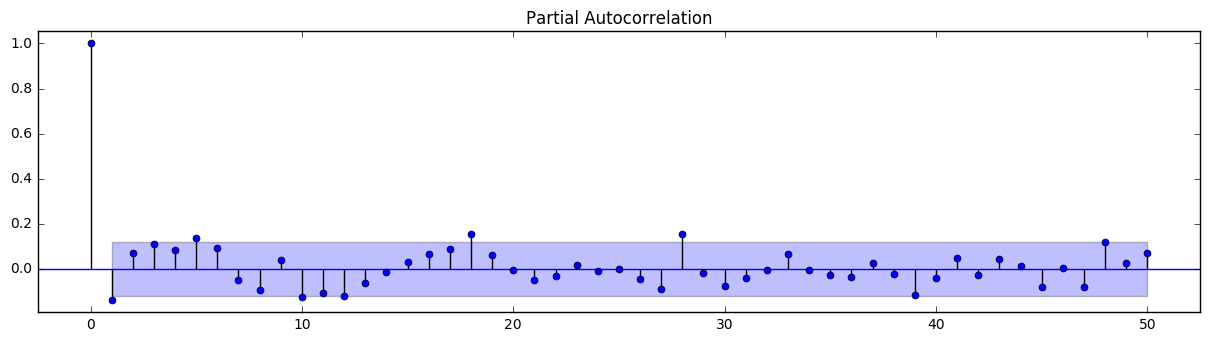

In [119]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.iloc[13:, 3].values.squeeze(), lags=50, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.iloc[13:, 3].values.squeeze(), lags=50, ax=ax)
plt.show()

In [124]:
ps = range(6)
d = 1
qs = range(6)
Ps = range(5)
D = 1
Qs = 0

In [125]:
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

180

Выводы:
* Нет выбросов автокорреляции в точках, кратных 12, поэтому в качестве начального приближения используем $Q = 0$.
* Среди других значений автокорреляции мы видим выброс в точке 28, который в расчет не берем, последнее ненулевое значение достигается в точке 10, поэтому положим $q = 10$.  
* Среди значений частичной автокорреляции в точках, кратных 12, мы видим ненулевые значения в точках 12 и 48, поэтому считаем  $P = 4$. 
* Среди других значений частичной автокорреляции мы видим выборосы в точках 18, 28 и 39, их мы в расчет не берем, последнее ненулевое значение достигается в точке 10, поэтому используем $p = 10$.

Замечание:
* Для поиска оптимальных параметров придется перебрать 605 моделей, что потребует весьма длительных вычислений. Поэтому в качестве компромисса будет использоваться модель ARIMA$(5, 1, 5)\times(4, 1, 0)$, для которой необходимо перебрать 180 возможных комбинаций. 

## 4) Подбор оптимальных параметров

Методом перебора всех возможных комбинаций параметров $p, P, q, Q$ найдем оптимальные, то есть те, которые минимизируют информационный критерий Акаике.

In [126]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, Qs, 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0)
wrong parameters: (1, 2, 0)
wrong parameters: (1, 2, 1)
wrong parameters: (1, 2, 2)
wrong parameters: (1, 2, 3)
wrong parameters: (1, 2, 4)
wrong parameters: (2, 1, 0)
wrong parameters: (2, 1, 1)
wrong parameters: (2, 1, 2)
wrong parameters: (2, 1, 3)
wrong parameters: (2, 1, 4)
wrong parameters: (2, 2, 0)
wrong parameters: (2, 2, 1)
wrong parameters: (2, 2, 2)
wrong parameters: (2, 2, 3)
wrong parameters: (2, 2, 4)
wrong parameters: (3, 2, 0)
wrong parameters: (3, 2, 1)
wrong parameters: (3, 2, 2)
wrong parameters: (3, 2, 3)
wrong parameters: (3, 2, 4)
wrong parameters: (4, 2, 0)
wrong parameters: (4, 2, 1)
wrong parameters: (4, 2, 2)
wrong parameters: (4, 2, 3)
wrong parameters: (4, 2, 4)
wrong parameters: (4, 4, 0)
wrong parameters: (4, 4, 1)
wrong parameters: (4, 4, 2)
wrong parameters: (4, 4, 3)
wrong parameters: (4, 4, 4)
wrong parameters: (5, 2, 0)
wrong parameters: (5, 2, 1)
wrong parameters: (5, 2, 2)
wrong parameters: (5, 2, 3)
wrong parameters: (5

In [127]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

    parameters        aic
130  (5, 5, 1) -25.933710
131  (5, 5, 2) -24.664812
129  (5, 5, 0) -22.795649
133  (5, 5, 4) -22.596356
132  (5, 5, 3) -22.515032
50   (1, 5, 1) -15.867143
94   (3, 5, 0) -15.113397
51   (1, 5, 2) -14.851643
95   (3, 5, 1) -14.821166
96   (3, 5, 2) -14.045550


Мы получили, что оптимальные коэффициенты следующие: $p = 5, d = 1, q = 5, P = 1, D = 1, Q = 0$, то есть ARIMA$(5, 1, 5)\times(1, 1, 0)$.

## 5) Исследование лучшей модели

Мы исследуем лучшую модель и ее остатки, а также сравним ее график с исходым рядом.

In [128]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.967
Date:                            Fri, 17 Mar 2017   AIC                            -25.934
Time:                                    16:57:41   BIC                             17.854
Sample:                                01-01-1993   HQIC                            -8.378
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0377      4.334      0.009      0.993      -8.458       8.533
ar.L2          0.0125      3.006   

Student test's p-value: p=0.176321
Dickey-Fuller test's p-value: p=0.000000


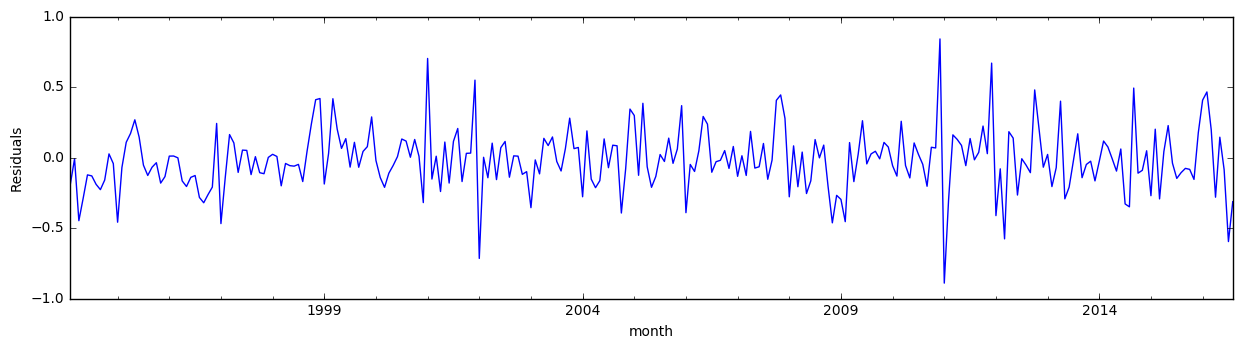

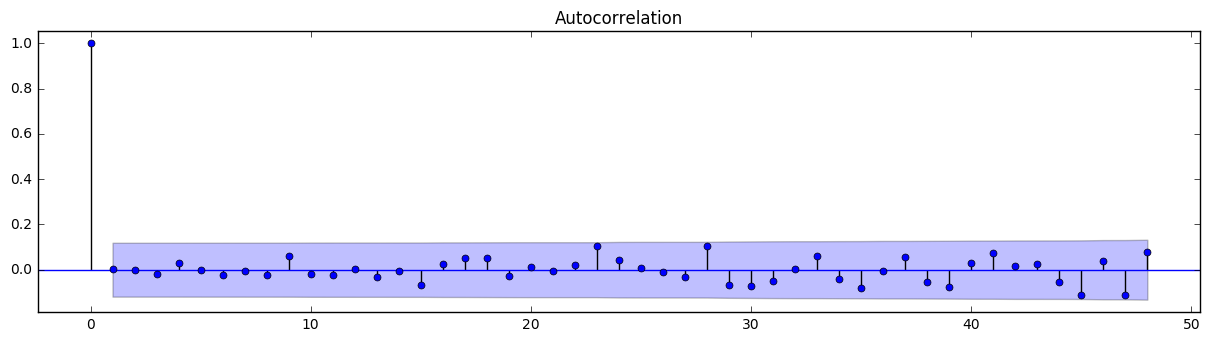

In [129]:
print("Student test's p-value: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test's p-value: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

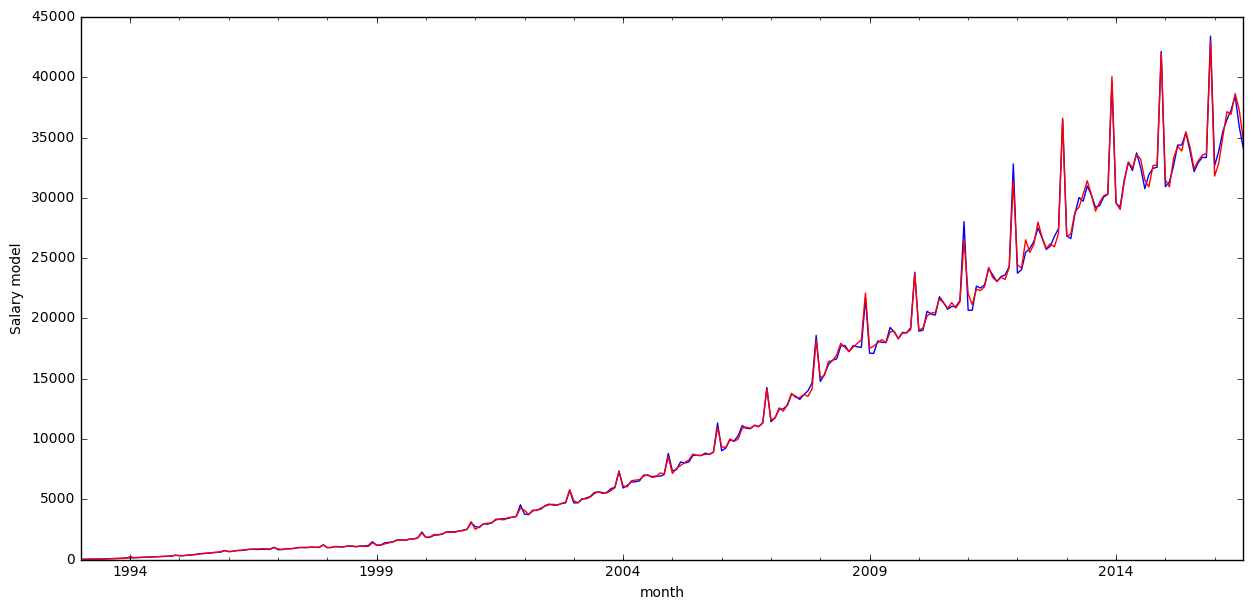

In [131]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary['WAG_C_M'].plot()
salary['model'].plot(color='r')
plt.ylabel('Salary model')
pylab.show()

Выводы:
* Оптимальной моделью, минимизирующей информационный критерий Акаике, является модель ARIMA$(5, 1, 5)\times(1, 1, 0)$, при этом значение критерия равно -25.93.
* Остатки данной модели являются несмещенными (p_value теста Стьюдента равно 0.18), без автокорреляции (p_value теста Льюнг-Бокса равно 0.97) и стационарными (нулевое p_value теста Дики-Фуллера).
* Из графика видно, что наша модель весьма хорошо описывает данные.

## 6) Прогнозирование по лучшей модели

Используя лучшую модель, спрогнозируем среднюю зарплату на два года вперед. Также доступны данные с сентября по январь, сравним спрогнозированные результаты с реальными.

In [140]:
real_salary = np.array([35843, 35749, 36195, 47554, 35650])

In [141]:
salary2 = salary[['WAG_C_M']]
future_dates = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=future_dates, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

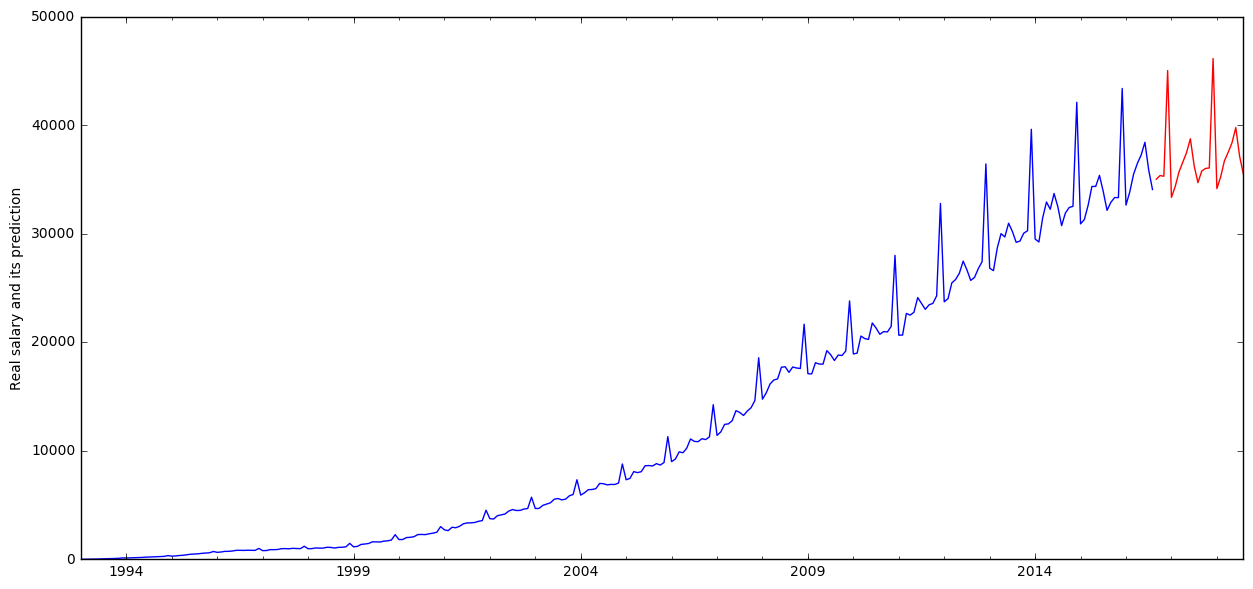

In [143]:
plt.figure(figsize(15,7))
salary2['WAG_C_M'].plot()
salary2['forecast'].plot(color='r')
plt.ylabel('Real salary and its prediction')
plt.show()

In [144]:
predict_salary = salary2.iloc[284:289, 1].values
error = 0.2 * np.sum(abs(real_salary - predict_salary))
sq_error = np.sqrt(0.2 * np.sum((real_salary - predict_salary)**2))
print('Mean absolute error of salary from 09/2016 to 01/2017: MAE = %f' % error)
print('Mean squared error of salary from 09/2016 to 01/2017: MSE = %f' % sq_error)

Mean absolute error of salary from 09/2016 to 01/2017: MAE = 1364.641489
Mean squared error of salary from 09/2016 to 01/2017: MSE = 1611.885189


Выводы:
* по графику видно, что модель весьма точно передает сезонность и возрастающий тренд заработной платы
* средняя квадратическая ошибка для пяти месяцев, для которых уже известна средняя заработная плата, составляет всего лишь 1600 рублей, весьма неплохой результат